# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime



In [ ]:
df = pd.read_csv("movie_statistic_dataset.csv")
df.columns = df.columns.str.lower().str.replace('$', '').str.replace(' ', '_')

<ipython-input-468-28621a4cda64>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace('$', '').str.replace(' ', '_')


In [ ]:
# Custom function to split the string and fill in "No Genre" if elements are missing;
# "No Genre" is better than NA in this scenario because we are going to encode the column later on
def split_genres(s):
    genres = s.split(",")
    if len(genres) >= 3:
        return genres[0], genres[1], genres[2]
    elif len(genres) == 2:
        return genres[0], genres[1], "No Genre"
    elif len(genres) == 1:
        return genres[0], "No Genre","No Genre"
    else:
        return "No Genre","No Genre","No Genre"

# Apply the custom function to create new columns
df['genre1'], df['genre2'], df['genre3'] = zip(*df['genres'].apply(split_genres))

#custom function to split director_professions
def split_jobs(s):
    jobs = s.split(",")
    if len(jobs) >= 3:
        return jobs[0], jobs[1], jobs[2]
    elif len(jobs) == 2:
        return jobs[0], jobs[1], "No director"
    elif len(jobs) == 1:
        return jobs[0], "No director","No director"
    else:
        return "No director","No director","No director"

# Apply the custom function to create new columns
#df['job1'], df['job2'], df['job3'] = zip(*df['director_professions'].apply(split_jobs))




In [ ]:
#handling these NAs in a specific manner because the columns are being encoded
df['genre1'].replace("\\N","No Genre",inplace = True)
#df['job1'].replace(np.nan,"No director",inplace = True)
#replace "-" and "\N" with null
df.replace("-",np.nan,inplace = True)
df.replace("\\N",np.nan,inplace = True)
#changing missing years to zeroes; open to different ideas
df['director_birthyear'].replace(np.nan,0,inplace=True)
df['director_deathyear'].replace(np.nan,0,inplace=True)
df['director_deathyear'].replace("alive",0,inplace=True)

In [ ]:
#check for null values; we ignore the string columns
df.isnull().sum()

movie_title               0
production_date           0
genres                    2
runtime_minutes           0
director_name           326
director_professions    333
director_birthyear        0
director_deathyear        0
movie_averagerating       0
movie_numerofvotes        0
approval_index            0
production_budget_        0
domestic_gross_           0
worldwide_gross_          0
genre1                    0
genre2                    0
genre3                    0
dtype: int64

In [ ]:
#I want to break out the production date column; also, fairly certain production means release date
from datetime import datetime
df['year'] = df.production_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').year)
df['month'] = df.production_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d').month)
#creating a season column so we can analyze by season if we want; I suspect summer matters, at least historically
season_dict = {1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",
               7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Winter"}
df['season'] = df.production_date.apply(lambda x:season_dict[datetime.strptime(x, '%Y-%m-%d').month])

In [ ]:
#I want to take a look at correlation after encoding different columns
one_hot_encoded = pd.get_dummies(df['season'])
df_encoded = pd.concat([df, one_hot_encoded], axis=1)

In [ ]:
one_hot_encoded = pd.get_dummies(df['genre1'])
df_encoded = pd.concat([df, one_hot_encoded], axis=1)


In [ ]:
#one_hot_encoded = pd.get_dummies(df['job1'])
#df_encoded = pd.concat([df, one_hot_encoded], axis=1)

Check which columns weren't created by the hot encoding above

In [ ]:
print(set([name for name in list(df["genre2"]) + list(df["genre3"])  if name not in df_encoded.columns]))
new_cols = set([name for name in list(df["genre2"]) + list(df["genre3"]) if name not in df_encoded.columns])


{'Sport', 'War', 'History', 'News'}


In [ ]:
for c in new_cols:
  df_encoded[c] = [0] * len(df_encoded)

Here I want to fix the encoding so that genres 2 and 3 are accounted for

In [ ]:
for row in range(len(df_encoded)):

  df_encoded[df["genre2"][row]][row] += 1
  df_encoded[df["genre3"][row]][row] += 1
  #df_encoded[df["job2"][row]][row] += 1
  #df_encoded[df["job3"][row]][row] += 1



<ipython-input-478-c6b8a34bfdb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[df["genre2"][row]][row] += 1
<ipython-input-478-c6b8a34bfdb7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[df["genre3"][row]][row] += 1


In [ ]:
#checking to make sure the encoding worled; note the 1s in Action Adventure and Fantasy columns
df_encoded.iloc[0,:30]

movie_title             Avatar: The Way of Water
production_date                       2022-12-09
genres                  Action,Adventure,Fantasy
runtime_minutes                            192.0
director_name                      James Cameron
director_professions    writer,producer,director
director_birthyear                          1954
director_deathyear                             0
movie_averagerating                          7.8
movie_numerofvotes                      277543.0
approval_index                          7.061101
production_budget_                     460000000
domestic_gross_                        667830256
worldwide_gross_                      2265935552
genre1                                    Action
genre2                                 Adventure
genre3                                   Fantasy
year                                        2022
month                                         12
season                                    Winter
Action              

2233

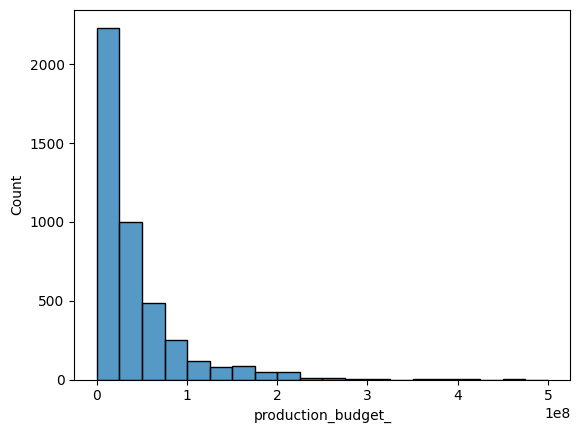

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df["production_budget_"], binwidth = 25000000, binrange = (0,500000000))
len(df[df.production_budget_ < 25000000])

<Axes: xlabel='production_budget_'>

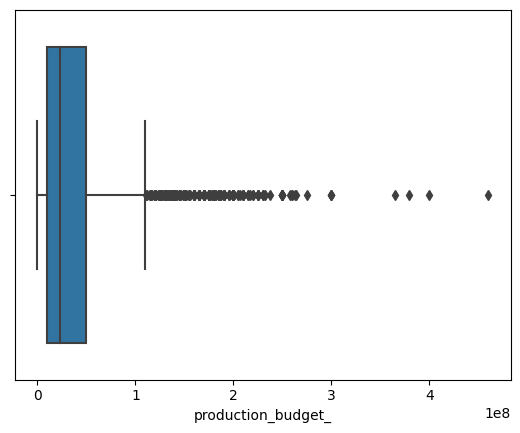

In [ ]:
sns.boxplot(x = df.production_budget_)

3668

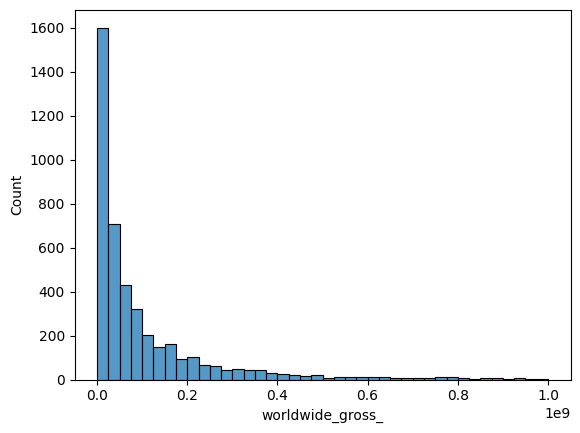

In [ ]:
sns.histplot(df["worldwide_gross_"], binwidth = 25000000, binrange = (0,1000000000))
len(df[df.worldwide_gross_ < 200000000])

<Axes: xlabel='worldwide_gross_'>

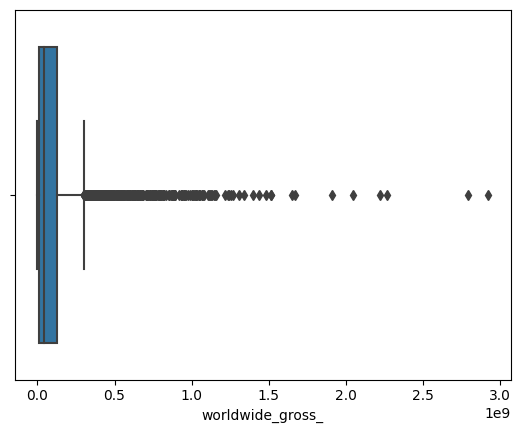

In [ ]:
sns.boxplot(x = df.worldwide_gross_)

In [ ]:
((np.percentile(df.production_budget_,75) - np.percentile(df.production_budget_,25) ) * 1.5) +  np.percentile(df.production_budget_,75)

110000000.0

In [ ]:
df_encoded['ratio'] = df['worldwide_gross_'] / df['production_budget_']

In [ ]:
#data = df_encoded[df_encoded.production_budget_ <= 11000000]

labels = df_encoded["worldwide_gross_"]
#labels = df_encoded['ratio']
data = df_encoded.drop(labels = ["movie_title","production_date","genres","director_name","director_professions",
                           "domestic_gross_","worldwide_gross_","genre1","genre2","genre3","season","ratio"], axis = 1)


In [ ]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 100)

In [ ]:
#train the model
reg = LinearRegression().fit(train_data, train_labels)
#R^2 score
print(f"The value of R^2 is {reg.score(test_data,test_labels)}")
#this creates a list of tuples (real, predicted) in case you want to look
predictions_true = [(j,reg.predict(np.array(i).reshape(1, -1))) for i,j in zip(test_data,test_labels)]
#Mean Squared Error
mean_squared_error = sum([(j - reg.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(test_data,test_labels)]) / len(test_data)
#Standard Error
print(f"The standard error is {mean_squared_error[0]**0.5}")

The value of R^2 is 0.6940055790048394
The standard error is 116173298.6759156


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
r_average = [0] * 33
for trial in range(100):
  rsquareds = []
  for num in range(1,34):
    #feature selection algorithm is always ran on same random state
    scaled_data = scale(data, axis = 0)
    train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2,random_state=2308)
    k_best = SelectKBest(f_regression, k=num)
    X_new = k_best.fit_transform(train_data, train_labels)
    indices = k_best.get_support(indices=True)
    regression_cols = [data.columns[i] for i in indices]
    #choosing columns from the dataset and scaling
    new_data = data[regression_cols]
    new_scaled_data = scale(new_data, axis = 0)
    #no random state specified here so it will always be randomized
    train_data, test_data, train_labels, test_labels = train_test_split(new_scaled_data, labels, test_size = 0.2)
    #train the model
    reg = LinearRegression().fit(train_data, train_labels)
    rsquareds.append(reg.score(test_data,test_labels))
  r_average = [i + j for i,j in zip(rsquareds,r_average)]


<function matplotlib.pyplot.show(close=None, block=None)>

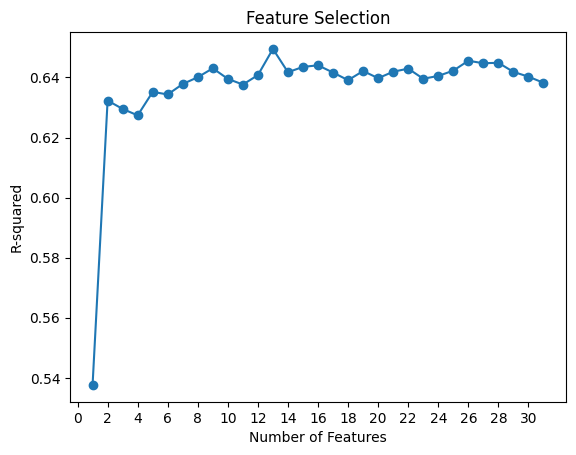

In [ ]:
x = [i for i in range(1,32)]
y = [i/100 for i in r_average][:31]
plt.plot(x,y, marker = "o")
plt.xlabel("Number of Features")
plt.ylabel("R-squared")
plt.xticks([i for i in range(0,32,2)])
plt.title("Feature Selection")
plt.show

In [ ]:
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2,random_state=2308)
k_best = SelectKBest(f_regression, k=13)
X_new = k_best.fit_transform(train_data, train_labels)
indices = k_best.get_support(indices=True)
regression_cols = [data.columns[i] for i in indices]
new_data = data[regression_cols]
new_scaled_data = scale(new_data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(new_scaled_data, labels, test_size = 0.2)
#train the model
reg = LinearRegression().fit(train_data, train_labels)
print(f"The value of R^2 is {reg.score(test_data,test_labels)}")
#this creates a list of tuples (real, predicted) in case you want to look
predictions_true = [(j,reg.predict(np.array(i).reshape(1, -1))[0]) for i,j in zip(test_data,test_labels)]
#Mean Squared Error
mean_squared_error = sum([(j - reg.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(test_data,test_labels)]) / len(test_data)
#Standard Error
print(f"The standard error is {mean_squared_error[0]**0.5}")

The value of R^2 is 0.6672318222945117
The standard error is 105344696.53055456


In [ ]:
regression_cols

['runtime_minutes',
 'movie_averagerating',
 'movie_numerofvotes',
 'approval_index',
 'production_budget_',
 'year',
 'Action',
 'Adventure',
 'Animation',
 'Drama',
 'No Genre',
 'Romance',
 'Sci-Fi']

In [ ]:

#romance
barbie = np.array([114,7.4,202000,7,145000000,2023,0,0,0,0,0,1,0])
#drama
oppenheimer = np.array([180,8.6,311000,8,100000000,2023,0,0,0,1,0,0,0])


In [ ]:
barbie = scale(barbie, axis = 0)
print(f"Barbie's predicted gross is {reg.predict(barbie.reshape(1, -1))[0]} and the true gross is 1.05 billion")
oppenheimer = scale(oppenheimer, axis = 0)
print(f"Oppenheimer's predicted gross is {reg.predict(oppenheimer.reshape(1, -1))[0]} and the true gross is 552.9 million")

Barbie's predicted gross is 493938672.6627519 and the true gross is 1.05 billion
Oppenheimer's predicted gross is 494314393.9729307 and the true gross is 552.9 million


Trying out some different models; completely unfinished

# Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

#choosing columns from the dataset and scaling
data = df_encoded.drop(labels = ["movie_title","production_date","genres","director_name","director_professions","director_birthyear",
             "director_deathyear","production_budget_","domestic_gross_","worldwide_gross_","genre1","genre2","genre3","season"], axis = 1)
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 4)

regr = ElasticNet(random_state=0)
regr.fit(train_data, train_labels)

regr.score(test_data,test_labels)

0.45750157369872446

In [ ]:
#ElasticNet has built in variable selection
print(regr.n_features_in_)

29


# Ridge

In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(train_data, train_labels)

Ridge()

In [ ]:
clf.score(test_data, test_labels)

0.4992729446662538

In [ ]:
#Mean Squared Error
mean_squared_error = sum([(j - clf.predict(np.array(i).reshape(1, -1)))**2 for i,j in zip(test_data,test_labels)]) / len(test_data)
#Standard Error
print(f"The standard error is {mean_squared_error[0]**0.5}")

The standard error is 142987814.46649146


In [ ]:
#trying it with less features
data = df_encoded[regression_cols]
scaled_data = scale(data, axis = 0)
train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 4)

clf = Ridge(alpha=1.0)
clf.fit(train_data, train_labels)

clf.score(test_data,test_labels)


0.49899780661014836